# Quality Analysis over the DB search with the models

### Imports

In [1]:
import boto3
import csv
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
from openpyxl import load_workbook

### Connection to S3 bucket

In [2]:
# path = 'C:/Users/jordi/Documents/claus/'
path = '/home/propietari/Documents/claus/'
filename = 'AWS_S3_keys_wri.json'
file = path + filename
with open(file, 'r') as dict:
    credentials = json.load(dict)
                                      
KEY = list(credentials)[0]
SECRET = list(credentials.values())[0]
# s3BucketName = "wri-testing"
s3BucketName = "wri-nlp-policy"
# region = 'eu-central-1'
region = "us-east-1"

s3 = boto3.resource(
    service_name = 's3',
    region_name = region,
    aws_access_key_id = KEY,
    aws_secret_access_key = SECRET
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/propietari/Documents/claus/AWS_S3_keys_wri.json'

## Praparation of the sentences for QA

The QA is performed in the following way:
1. A random sample of 50 documents, containing at least one incentive, is choosen for each language.
2. From each document the sentences and the labels are retrieved and saved as an excel file.
3. From each of the above documents, a random sample of non-incentive sentennces is selected. The size of the sample is the same than the number of incentive sentences in the same document. In this way there are the same number of incentives and non-incentives from each document. The results are saved in a an excel file.

The excel files containing the taged sentences are transfered to the human analist who will confirm the labeling done by the model.

### Random picking of documents with incentives

In [ ]:

language = "spanish"

In [ ]:
# The code below is to pick random document codes from the list of documents with incentives
model = "simple_transformers"
path = "../output/"
# file_name = f"incentives_{language}.csv"
file_name = f"incentives_{model}_{language}.csv"
file = path + file_name

with open(file, newline='') as f:
    reader = csv.reader(f)
    next(reader)
    file_code = [row[0] for row in reader]

codes = {}
for item in random.sample(file_code, 50):
    codes[item] = 0

### Retrieve the sentences labeled as incentives

In [ ]:
# To pick the sentences refering to incentives from the selected documents

# in_prefix = f"{language}_documents/HSSC/updated_sentences/"  
in_prefix = f"{language}_documents/HSSC/{model}/updated_sentences/"  

i = 0
documents_with_incentives = 0
results_list = [["Sentence_name", "Sentence text", "Label"]]

incentives = 0
for obj in s3.Bucket(s3BucketName).objects.all().filter(Prefix = in_prefix):
    name = obj.key.split("/")[-1].split("_")[0]
#     print(name)
    if name in codes :
        sentences = json.loads(obj.get()['Body'].read().decode('utf-8'))
        for sentence_id in sentences[name]["sentences"]:
            incentive = sentences[name]["sentences"][sentence_id]["label"]
            if len(incentive) > 1 and incentive[0] == "Incentive":
                incentives += 1
                results_list.append([])
                results_list[incentives].append(name)
                results_list[incentives].append(sentences[name]["sentences"][sentence_id]["text"])
                results_list[incentives].append(incentive[1])
                
with open(f"../output/incentive_sentences_{model}_{language}.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(results_list)           

In [ ]:
# The code below is to retrieve de document codes of the sentences which refer to incentives 
# that has been selected in the previous cell. 
# This is only in  case you execute the next cell after restarting the kernel. Otherwise, the "codes" dictionary is already set.

path = "../output/"
file_name = f"incentive_sentences_{model}_{language}.csv"
file = path + file_name

with open(file, newline='') as f:
    reader = csv.reader(f)
    next(reader)
    file_code = [row[0].split("_")[0] for row in reader]

codes = {}
for item in file_code:
    codes[item] = 0

### Retrieve sentences labeled as non-incentives

In [ ]:
# To pick up the sentences refering to non-incentives from the selected documents
# (1) We first retrieve the documents that where selected to pickup incentives
# (2) Next we collect all non-incentive sentences
# (3) Finally we ramdomly select the same number of non-incentive sentences as there where incentive centences.

in_prefix = f"{language}_documents/HSSC/{model}/updated_sentences/"  

i = 0
documents_with_incentives = 0
results_list = [["Sentence_name", "Sentence text", "Label"]]


for obj in s3.Bucket(s3BucketName).objects.all().filter(Prefix = in_prefix):
    name = obj.key.split("/")[-1].split("_")[0]
#     print(name)
    if name in codes :
        sentences = json.loads(obj.get()['Body'].read().decode('utf-8'))
        n_incentives = incentive = sentences[name]["metadata"]["number_of_incentives"]
#        print(n_incentives)
        non_incentives = [[]]
        incentives = 0
        for sentence_id in sentences[name]["sentences"]:
            incentive = sentences[name]["sentences"][sentence_id]["label"]
            if len(incentive) == 1 and incentive[0] == "not_Incentive":
                non_incentives.append([])
                incentives += 1
                non_incentives[incentives].append(name)
                non_incentives[incentives].append(sentences[name]["sentences"][sentence_id]["text"])
                non_incentives[incentives].append(incentive[0])
        
        for item in random.sample(non_incentives, n_incentives):
            results_list.append(item)
                
                
with open(f"../output/non_incentive_sentences_{model}_{language}.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(results_list)          

### Processing of the reviewed sentences

The post-annotation system that we have used, consists of confirming the labels of the model's classification. We have two types of data:
* Sentences that the model has classified first as incentives and then classified as one of the six instruments. We are going to call them *Predicted positives* PP.
* Sentences that the model has classified as not incentives. We are going to call them *predicted negatives* PN
The analist has classified each label into four different categories:
1. Category 1 is for sentences which have been correctly classified as incentives with the right policy instrument.
2. Category 2 is for sentences that refer to a policy instrument, but that are not incentives, they may refer to social benefits or other types of assistance.
3. Category 3 is for sentences that even they refer to some incentive, it is not related to any of the policy instruments under consideration.
4. Category 4 is for sentences that are plainly missclassified, they are not incentives nor they are similar to policy instruments.

In practical terms, the files where the analist has been annotating the sentences contains two labeling columns, the first one is called "Incentive?" and the second one "Correct instrument?" the values are 0 or 1 as False and True values. Thus, (0,0) are category 4 sentences, (1,0) are category 3 sentences, (0,1) are category 2 sentences and (1,1) sentences are category 1 sentences.

With the available data the following evaluation metrics can be computed:

1. PPV for incentives
2. FOR for incentives
3. Average PPV for instruments
4. Specific PPV for each instrument


In [26]:
path = "../input/"
incentives = ["incentive", "non_incentive"]
models = ["sentences", "sentences_simple_transformers"]
languages = ["english", "spanish"]

lst_ppv_occurrences = []
color_counter = 0
color_dict = {1 : "r", 2 : "b", 3 : "g", 4 : "y", 5 : "c", 6 : "k"}
incentive_color_dict = {"Technical assistance" : "r", "Direct payment" : "b", "Loan" : "g", "Tax benefit" : "y", "Supplies" : "m", "Fine" : "k"}
language_marker_dict = {"english" : 'e', "spanish" :'s'}

for language in languages:
    marker = language_marker_dict[language]
    for model in models:
        for incentive in incentives:
            filename = f"{incentive}_{model}_{language}.xlsx"
            file = path + filename
            print(file)
            df = pd.read_excel(file, engine='openpyxl', usecols = "A:E")#, sheet_name = f"{incentive}_{model}_{language}"
            cols = df.columns.values
            print(f"\n{filename}")
            if incentive == "incentive":
                instruments = df[cols[2]].unique()
                PPV = round(df[df[cols[3]] == 1].count()[cols[3]]/len(df), 2)
                print(f"PPV for incentives is {PPV}")
                if len(instruments) == 6:
                    PPV = round(df[df[cols[4]] == 1].count()[cols[4]]/len(df), 2)
                    print(f"PPV for intruments is {PPV}")
                    for instrument in instruments:
                        PPV = round(df[(df[cols[2]] == instrument) & (df[cols[4]] == 1)].count()[cols[2]]/df[df[cols[2]] == instrument].count()[cols[2]], 2)
                        n_items_model = len(df[df[cols[2]] == instrument])
                        n_items_labeler = df[(df[cols[2]] == instrument) & (df[cols[4]] == 1)].count()[cols[2]]
                        lst_ppv_occurrences.append([instrument, PPV, n_items_model, n_items_labeler, incentive_color_dict[instrument], marker])
                        print(f"There are {n_items_model} datapoints of instrument {instrument} out od which {n_items_labeler} have been confirmed by the labeler")
                        print(f"PPV for {instrument} is {PPV}")
                else:
                    print("WARNING! the number of policy instruments is not six")

            elif incentive == "non_incentive":
                FOR = round(df[df[cols[3]] == 0].count()[cols[3]]/len(df), 2)
                print(f"FOR for non-incentives is {FOR}")
# print(f"Instruments are {instr}")
# print(f"The length of the file is: {len(df)}")
# # print(f"The values of the column \"{cols[3]}\" are {df[cols[3]].unique()} and there are ")
# print(f"\t\tCounts for incentive labels\n{df.groupby(cols[3]).count()}")
# print(f"\n\t\tCounts for instrument labels\n{df.groupby(cols[4]).count()}")
# policy_instrument = {}
# for index, row in df.iterrows():
#     if row['Policy instrument'] in policy_instrument:
#         policy_instrument[row['Policy instrument']] = policy_instrument[row['Policy instrument']] + 1
#     else:
#         policy_instrument[row['Policy instrument']] = 1

../input/incentive_sentences_english.xlsx

incentive_sentences_english.xlsx
PPV for incentives is 0.42
PPV for intruments is 0.69
There are 18 datapoints of instrument Fine out od which 6 have been confirmed by the labeler
PPV for Fine is 0.33
There are 16 datapoints of instrument Supplies out od which 0 have been confirmed by the labeler
PPV for Supplies is 0.0
There are 34 datapoints of instrument Tax benefit out od which 18 have been confirmed by the labeler
PPV for Tax benefit is 0.53
There are 156 datapoints of instrument Loan out od which 146 have been confirmed by the labeler
PPV for Loan is 0.94
There are 184 datapoints of instrument Direct payment out od which 120 have been confirmed by the labeler
PPV for Direct payment is 0.65
There are 18 datapoints of instrument Technical assistance out od which 5 have been confirmed by the labeler
PPV for Technical assistance is 0.28
../input/non_incentive_sentences_english.xlsx

non_incentive_sentences_english.xlsx
FOR for non-incentives

In [27]:
lst_ppv_occurrences

[['Fine', 0.33, 18, 6, 'k', 'e'],
 ['Supplies', 0.0, 16, 0, 'm', 'e'],
 ['Tax benefit', 0.53, 34, 18, 'y', 'e'],
 ['Loan', 0.94, 156, 146, 'g', 'e'],
 ['Direct payment', 0.65, 184, 120, 'b', 'e'],
 ['Technical assistance', 0.28, 18, 5, 'r', 'e'],
 ['Direct payment', 0.67, 159, 107, 'b', 'e'],
 ['Technical assistance', 0.41, 17, 7, 'r', 'e'],
 ['Fine', 0.79, 39, 31, 'k', 'e'],
 ['Supplies', 0.0, 10, 0, 'm', 'e'],
 ['Loan', 0.92, 59, 54, 'g', 'e'],
 ['Tax benefit', 0.78, 54, 42, 'y', 'e'],
 ['Tax benefit', 0.57, 21, 12, 'y', 's'],
 ['Direct payment', 0.55, 147, 81, 'b', 's'],
 ['Loan', 0.52, 29, 15, 'g', 's'],
 ['Technical assistance', 0.43, 175, 75, 'r', 's'],
 ['Fine', 0.71, 21, 15, 'k', 's'],
 ['Supplies', 0.36, 14, 5, 'm', 's'],
 ['Direct payment', 0.64, 265, 170, 'b', 's'],
 ['Fine', 0.78, 9, 7, 'k', 's'],
 ['Technical assistance', 0.64, 90, 58, 'r', 's'],
 ['Tax benefit', 0.44, 9, 4, 'y', 's'],
 ['Supplies', 0.5, 24, 12, 'm', 's'],
 ['Loan', 0.83, 6, 5, 'g', 's']]

In [28]:
lst_ppv_occurrences[lst_ppv_occurrences[5] == "e"]

['Fine', 0.33, 18, 6, 'k', 'e']

Text(0, 0.5, 'Occurences from the model')

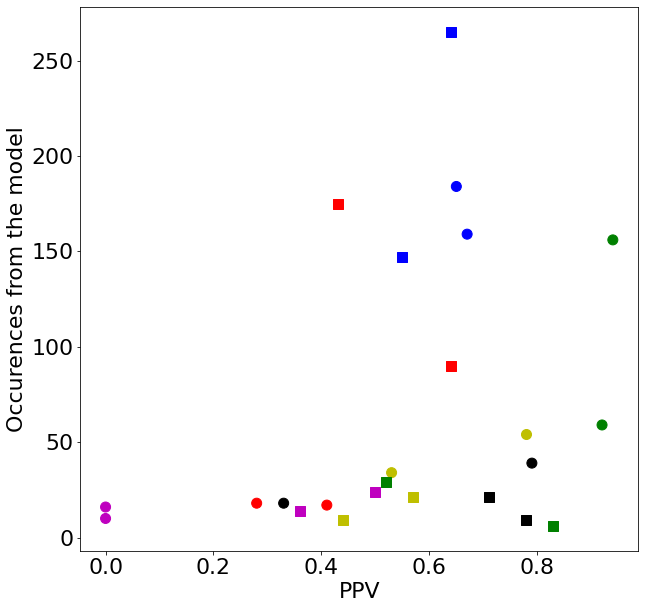

In [41]:
x = [row[1] for row in lst_ppv_occurrences if row[5] == "e"]
y = [row[2] for row in lst_ppv_occurrences if row[5] == "e"]
c = [row[4] for row in lst_ppv_occurrences if row[5] == "e"]
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 22})
plt.scatter(x, y , s = 100, c= c, marker = 'o')
x = [row[1] for row in lst_ppv_occurrences if row[5] == "s"]
y = [row[2] for row in lst_ppv_occurrences if row[5] == "s"]
c = [row[4] for row in lst_ppv_occurrences if row[5] == "s"]
plt.scatter(x, y , s = 100, c= c, marker = 's')
plt.xlabel("PPV")
plt.ylabel("Occurences from the model")
plt.title("Positive Predictive Value vs number of model labeled sentences")

Text(0, 0.5, 'Occurences from the labeler')

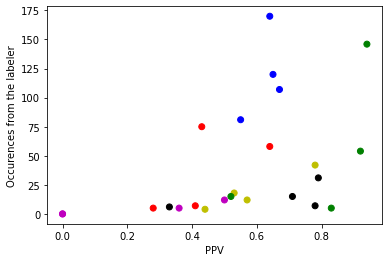

In [30]:
plt.scatter(transposed[1], transposed[3] , c= transposed[4])
plt.xlabel("PPV")
plt.ylabel("Occurences from the labeler")

In [23]:
df[(df[cols[2]] == instrument) & (df[cols[3]] == 1)]

,Sentence_name,Sentence text,Label,Incentive?,Correct instrument?
86,1d4756b6080454bc595852ede312f2b213401fe2,"Anyone taking, attempting to take, or otherwis...",Fine,1,1
286,61a4dde264607bbddfa3f8f4a477ead5c6a71568,This action would strengthen our enforcement o...,Fine,1,1
287,61a4dde264607bbddfa3f8f4a477ead5c6a71568,"Finally, we are proposing to require that any ...",Fine,1,1
288,61a4dde264607bbddfa3f8f4a477ead5c6a71568,The proposed uniform penalty protocol may bene...,Fine,1,1
302,7f500a8f818d080984d819aee645e76949cabb1e,Power to levy and collect fee: A Water User's ...,Fine,1,1
